# **Redes Neurais Artificiais**

Exemplo de uma MLP (Multi-Layer Perceptron):

<img src="https://github.com/OviedoVR/ML_especializacao_2025/blob/main/assets/figures/ann_mlp_illustration.png?raw=true" width="70%"/>

Fonte: ELGENDY, Mohamed. **Deep Learning for Vision Systems**. Shelter Island: Manning Publications, 2020

<br>

> **PROBLEMA DE NEGÓCIO:** uma empresa de cursos preparatórios busca prever a performance de seus estudantes em um exame de certificação e, com isso, propor ações e estratégias para promover uma maior taxa de aprovação. Para isso, tem-se dados históricos contendo `horas de estudo`, `horas de sono`, `atividades extracurriculares (s/n)`, `número de questões praticadas`, `notas anteriores` e `nota final (performance)`.

In [28]:
# -- Manipulação de dados:
import pandas as pd

# -- DataViz:
import matplotlib.pyplot as plt
import seaborn as sns

# -- Pré-processamento:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# RNA:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Processamento sem alocar 100% da GPU:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## **Coleta de dados e EDA**

In [29]:
!wget -q 'https://raw.githubusercontent.com/OviedoVR/ML_especializacao_2025/main/dados/student_performance.csv' -O 'student_performance.csv'

In [30]:
# dados:
dados = pd.read_csv('student_performance.csv')
dados.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [31]:
# amostra
dados = dados.sample(n=5000, random_state=42)
dados.shape

(5000, 6)

In [32]:
# tamanho do dataset:
dados.shape

(5000, 6)

In [33]:
# tipos de dado:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 6252 to 2764
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     5000 non-null   int64  
 1   Previous Scores                   5000 non-null   int64  
 2   Extracurricular Activities        5000 non-null   object 
 3   Sleep Hours                       5000 non-null   int64  
 4   Sample Question Papers Practiced  5000 non-null   int64  
 5   Performance Index                 5000 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 273.4+ KB


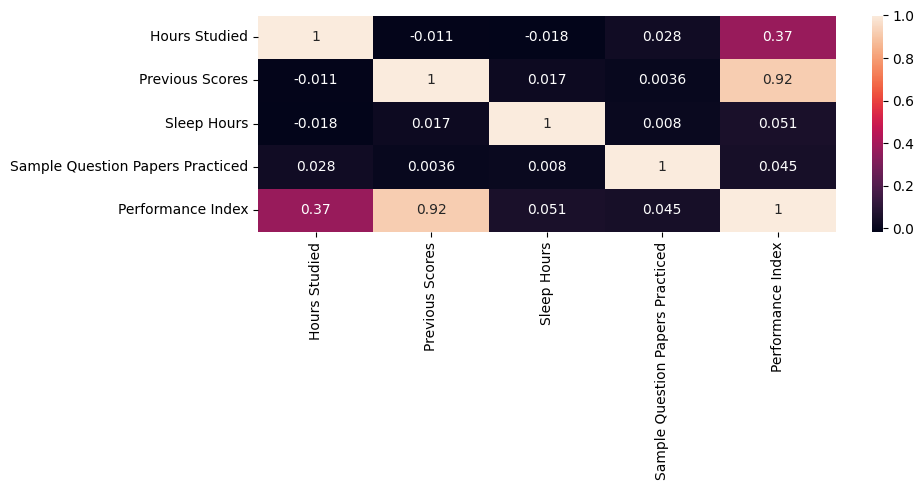

In [34]:
# Matriz de correlação:
dados_col_numericas = dados.select_dtypes(include='number')
fig, ax = plt.subplots(figsize=(10,5));
sns.heatmap(dados_col_numericas.corr(), annot=True);
plt.tight_layout();

Comentário:

* A coluna `Sample Question Papers Practiced` parece ter uma correlação fraca com a resposta (`Performance Index`), logo, iremos retirá-la da análise.

## **Modelagem: Regressão**

In [35]:
# ordem das colunas:
dados = dados[[
    'Hours Studied',
    'Sleep Hours',
    'Extracurricular Activities',
    'Previous Scores',
    'Performance Index'
]]

# resultado:
dados.head()

,Hours Studied,Sleep Hours,Extracurricular Activities,Previous Scores,Performance Index
6252,5,8,No,69,51.0
4684,2,4,Yes,46,20.0
1731,7,7,Yes,56,46.0
4742,6,8,Yes,42,28.0
4521,7,4,No,53,41.0


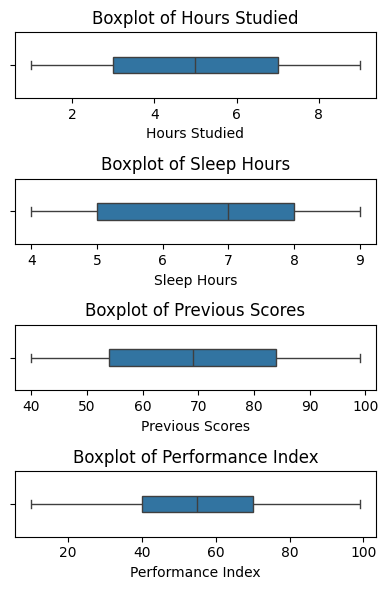

In [36]:
# Filtra colunas numéricas
num_cols = dados.select_dtypes(include=['number']).columns

# Cria uma figura
plt.figure(figsize=(4, len(num_cols) * 1.5))

# Loop para gerar boxplots
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 1, i + 1)
    sns.boxplot(data=dados, x=col, width=0.25)
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

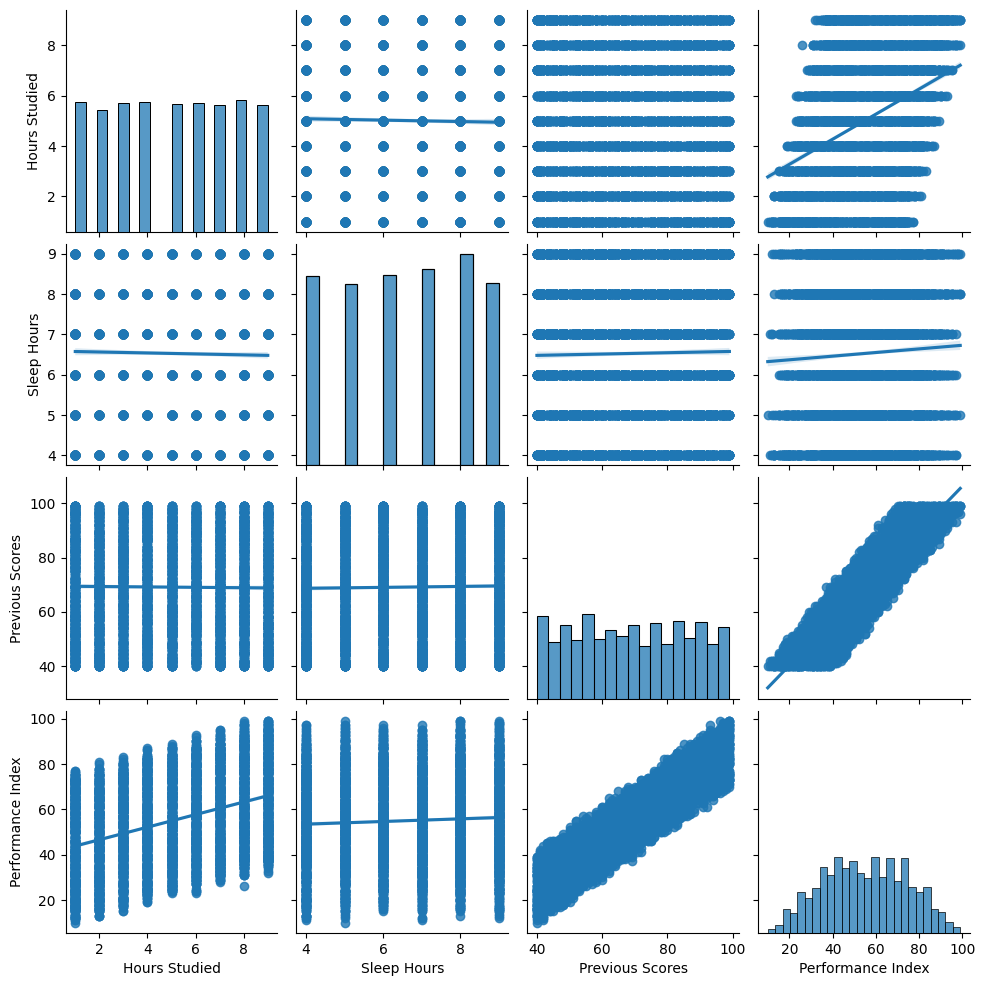

In [37]:
sns.pairplot(dados, kind='reg');

In [38]:
# codificação de variáveis categóricas:
dados['Extracurricular Activities'] = dados['Extracurricular Activities'].replace('No', 0).replace('Yes', 1)

/tmp/ipython-input-38-3040112522.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dados['Extracurricular Activities'] = dados['Extracurricular Activities'].replace('No', 0).replace('Yes', 1)


In [39]:
# Variáveis de entrada:
x = dados.drop(['Performance Index'], axis=1).to_numpy()
y = dados['Performance Index'].to_numpy()

# Treino/teste
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3,random_state=42)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(3500, 4)
(1500, 4)
(3500,)
(1500,)


In [40]:
# Scaling para features (x)
scaler_x = StandardScaler()

# Ajustar o scaler para os dados de treinamento e transformar
xtrain_std = scaler_x.fit_transform(xtrain)  # Ajusta e transforma
xtest_std = scaler_x.transform(xtest)        # Apenas transforma

# Scaling para variável resposta (y), se necessário
scaler_y = StandardScaler()

# Ajustar o scaler para a variável resposta de treinamento e transformar
ytrain_std = scaler_y.fit_transform(ytrain.reshape(-1, 1))  # Ajusta e transforma
ytest_std = scaler_y.transform(ytest.reshape(-1, 1))        # Apenas transforma

**Estruturando a RNA do tipo MLP**

1. Define uma RNA sequencial
2. Define a(s) camada(s) oculta(s)
3. Define parâmetros de compliação do modelo
4. Resumo

In [41]:
# Criação do modelo (camada de entrada com n features (dimensões), 1 camada oculta com 6 neurônios, 1 neurônio na camada de saída):
model = keras.Sequential()

# Camada 1:
model.add(layers.Dense(6,
                                        input_dim=xtrain_std.shape[1],
                                        activation='relu',
                                        kernel_regularizer=keras.regularizers.l1_l2()))

# Camada de saída:
model.add(layers.Dense(1))

# Compilação do Modelo
model.compile(loss='mean_squared_error',
                         optimizer=keras.optimizers.Adam(),
                         metrics=[tf.keras.metrics.R2Score])

# Resumo:
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 6)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

> **Documentação Keras**

* Loss: https://keras.io/api/losses/
* Metrics: https://keras.io/api/metrics/

> Nota:

* $R^2$, accuracy: `max`
* MAE, MSE, RMSE, entropy: `min`

**Avaliação da RNA antes de treinar o modelo**

In [42]:
score_train, metric_train = model.evaluate(xtrain_std, ytrain_std, verbose=0)
score_test, metric_test = model.evaluate(xtest_std, ytest_std, verbose=0)

print(f'R² no conjunto de treino: {round(metric_train*100, 1)}%')
print(f'R² no conjunto de teste: {round(metric_test*100, 1)}%')

R² no conjunto de treino: -20.3%
R² no conjunto de teste: -15.2%


**Predições**

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Text(0, 0.5, 'Y predito')

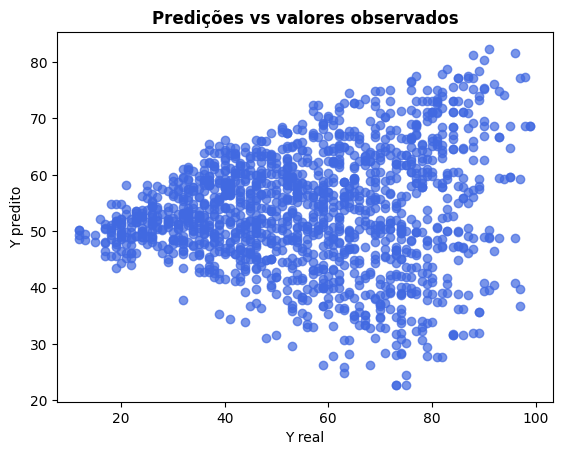

In [43]:
# Predições
ytrain_pred = scaler_y.inverse_transform(model.predict(xtrain_std))
ytest_pred = scaler_y.inverse_transform(model.predict(xtest_std))

fig, ax = plt.subplots()
plt.plot(ytest, ytest_pred, 'o', color='royalblue', alpha=0.7)
plt.title('Predições vs valores observados', weight='bold')
plt.xlabel('Y real')
plt.ylabel('Y predito')

**Treino da Rede Neural**

In [44]:
rna_earlystop = keras.callbacks.EarlyStopping(
    monitor="val_r2_score",
    min_delta=0.01,
    patience = 20,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

historico = model.fit(
    x=xtrain_std,
    y=ytrain_std,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=rna_earlystop
)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1190 - r2_score: -0.0855 - val_loss: 0.7475 - val_r2_score: 0.2268
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7090 - r2_score: 0.3189 - val_loss: 0.4472 - val_r2_score: 0.5375
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3959 - r2_score: 0.6089 - val_loss: 0.2564 - val_r2_score: 0.7348
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2204 - r2_score: 0.7811 - val_loss: 0.1487 - val_r2_score: 0.8462
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1265 - r2_score: 0.8707 - val_loss: 0.0921 - val_r2_score: 0.9048
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0786 - r2_score: 0.9225 - val_loss: 0.0653 - val_r2_score: 0.9325
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0594 - r2_score: 0.9424 - val_loss: 0.0510 - val_r2_score: 0.9472
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0491 - r2_score: 0.9517 - val_loss: 0.0424 - val_

**Desempenho**

In [45]:
score_train, metric_train = model.evaluate(xtrain_std, ytrain_std, verbose=0)
score_test, metric_test = model.evaluate(xtest_std, ytest_std, verbose=0)

print(f'R² no conjunto de treino: {round(metric_train*100, 1)}%')
print(f'R² no conjunto de teste: {round(metric_test*100, 1)}%')

R² no conjunto de treino: 97.5%
R² no conjunto de teste: 97.4%


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Text(0, 0.5, 'Y predito')

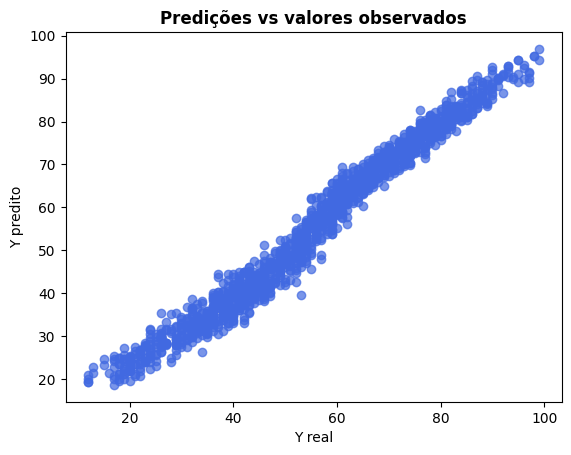

In [46]:
# Predições
ytrain_pred = scaler_y.inverse_transform(model.predict(xtrain_std))
ytest_pred = scaler_y.inverse_transform(model.predict(xtest_std))

fig, ax = plt.subplots()
plt.plot(ytest, ytest_pred, 'o', color='royalblue', alpha=0.7)
plt.title('Predições vs valores observados', weight='bold')
plt.xlabel('Y real')
plt.ylabel('Y predito')

In [47]:
historico.history.keys()

dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])

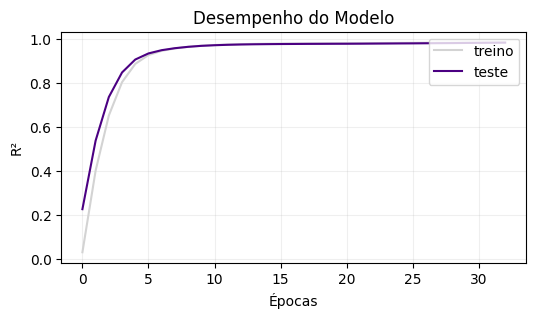

In [48]:
# Gráfico com a evolução do treinamento
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(historico.history['r2_score'], color='lightgray', label='treino')
plt.plot(historico.history['val_r2_score'], color='indigo', label='teste')
plt.title('Desempenho do Modelo')
plt.ylabel('R²')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.show()

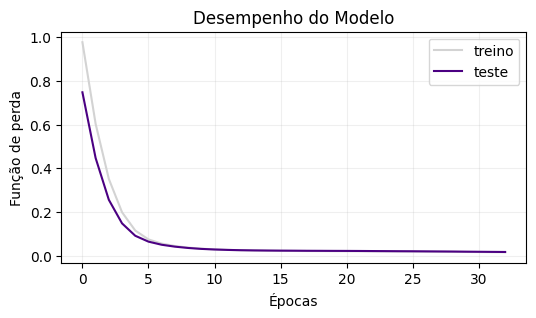

In [49]:
# Gráfico com a evolução do treinamento
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(historico.history['loss'], color='lightgray', label='treino')
plt.plot(historico.history['val_loss'], color='indigo', label='teste')
plt.title('Desempenho do Modelo')
plt.ylabel('Função de perda')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.show()

* Fazendo uma predição pontual:

In [50]:
ytest_raw = scaler_y.inverse_transform(ytest_std)

print(f'Valores y (real)\n{ytest_raw[0:5]}')
print('---'*10)
print(f'Valores de y (predito)\n{ytest_pred[0:5]}')

Valores y (real)
[[59.]
 [51.]
 [61.]
 [44.]
 [77.]]
------------------------------
Valores de y (predito)
[[63.458614]
 [47.71872 ]
 [60.95209 ]
 [41.950737]
 [74.01205 ]]


In [51]:
residuos = ytest_raw - ytest_pred
print('Resíduo')
print('---'*10)
print(residuos[0:5])

Resíduo
------------------------------
[[-4.45861435]
 [ 3.28128052]
 [ 0.04790878]
 [ 2.049263  ]
 [ 2.98795319]]


**Análise dos Resíduos**



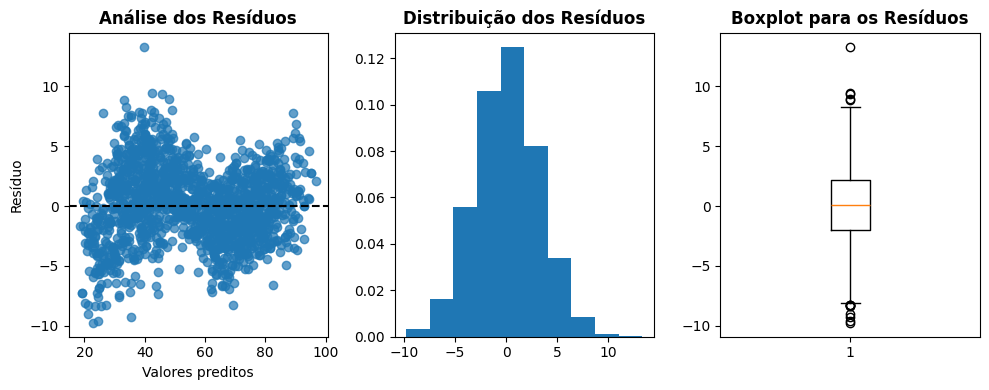

In [52]:
fig, ax = plt.subplots(1,3, figsize=(10,4));

# Sub-gráfico 1:
#plt.subplot(1,3,1);
ax[0].set_title('Análise dos Resíduos', weight='bold')
ax[0].plot(ytest_pred, residuos, 'o', alpha=0.7, );
ax[0].axhline(y=0, lw=1.5, ls='--', color='black');
ax[0].set_xlabel('Valores preditos')
ax[0].set_ylabel('Resíduo')

# Sub-gráfico 2:
#plt.subplot(1,3,2);
ax[1].set_title('Distribuição dos Resíduos', weight='bold')
ax[1].hist(residuos, density = True, histtype ='barstacked');

# Sub-gráfico 3:
#plt.subplot(1,3,3);
ax[2].set_title('Boxplot para os Resíduos', weight='bold')
ax[2].boxplot(residuos);

plt.tight_layout();

Ideal:

* Não possuir padrões no gráfico 1 (**dispersão** de valores preditos *versus* resíduos) e distribuição aleatória em torno de zero.
* Distribuição normal (gráfico 2 - **histograma**)
* Poucos outliers (gráfico 3 - **boxplot**)

> **Outro exemplo de Regressão** (documentação do Tensoflow): https://www.tensorflow.org/tutorials/keras/regression?hl=pt-br

## **Modelagem: Classificação**

In [53]:
# Obtendo classes como resposta (1: aprovado, 0: reprovado):
dados['Performance Index'] = dados['Performance Index'].apply(lambda registro: 1 if registro >= 70 else 0)

# Variáveis de entrada:
x = dados.drop('Performance Index', axis=1).to_numpy()
y = dados['Performance Index'].to_numpy()

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3,random_state=42)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(3500, 4)
(1500, 4)
(3500,)
(1500,)


In [54]:
# Scaling para features (x)
scaler_x = StandardScaler()

# Ajustar o scaler para os dados de treinamento e transformar
xtrain_std = scaler_x.fit_transform(xtrain)  # Ajusta e transforma
xtest_std = scaler_x.transform(xtest)        # Apenas transforma

**Estruturando a RNA do tipo MLP**

1. Define uma RNA sequencial
2. Define a(s) camada(s) oculta(s)
3. Define parâmetros de compliação do modelo
4. Resumo

In [55]:
# Criação do modelo (camada de entrada com n features (dimensões), 1 camada oculta com 6 neurônios, 1 neurônio na camada de saída):
model = keras.Sequential()

# Camada 1:
model.add(layers.Dense(6,
                                        input_dim=xtrain_std.shape[1],
                                        activation='tanh'))

# Caso queira camda de dropout:
#model.add(layers.Dropout(0.2))

# Camada de saída:
model.add(layers.Dense(1, activation='sigmoid'))

# Compilação do Modelo
model.compile(loss='binary_crossentropy',
                         optimizer=keras.optimizers.Adam(),
                         metrics=[keras.metrics.AUC(name='auc')])

# Resumo:
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 6)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

> **Documentação Keras**

* Loss: https://keras.io/api/losses/
* Metrics: https://keras.io/api/metrics/

> Nota:

* $R^2$, accuracy: `max`
* MAE, MSE, RMSE, entropy: `min`

**Treino da Rede Neural**

In [56]:
rna_earlystop = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    min_delta=0.01,
    patience = 20,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

historico = model.fit(
    x=xtrain_std,
    y=ytrain,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[rna_earlystop]
)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - auc: 0.7040 - loss: 0.6472 - val_auc: 0.8457 - val_loss: 0.5598
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8901 - loss: 0.5163 - val_auc: 0.9361 - val_loss: 0.4509
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9588 - loss: 0.4141 - val_auc: 0.9690 - val_loss: 0.3688
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9818 - loss: 0.3407 - val_auc: 0.9825 - val_loss: 0.3076
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9864 - loss: 0.2925 - val_auc: 0.9888 - val_loss: 0.2616
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9897 - loss: 0.2514 - val_auc: 0.9915 - val_loss: 0.2268
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.9936 - loss: 0.2164 - val_auc: 0.9933 - val_loss: 0.2000
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9967 - loss: 0.1854 - val_auc: 0.9943 - val_loss: 0.1789
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9968

**Desempenho**

In [57]:
score_train, metric_train = model.evaluate(xtrain_std, ytrain, verbose=0)
score_test, metric_test = model.evaluate(xtest_std, ytest, verbose=0)

print(f'AUC no conjunto de treino: {round(metric_train*100, 1)}%')
print(f'AUC no conjunto de teste: {round(metric_test*100, 1)}%')

AUC no conjunto de treino: 99.5%
AUC no conjunto de teste: 99.6%


In [58]:
historico.history.keys()

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])

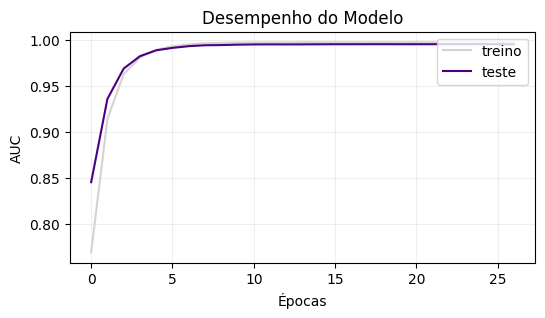

In [59]:
# Gráfico com a evolução do treinamento
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(historico.history['auc'], color='lightgray', label='treino')
plt.plot(historico.history['val_auc'], color='indigo', label='teste')
plt.title('Desempenho do Modelo')
plt.ylabel('AUC')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.show()

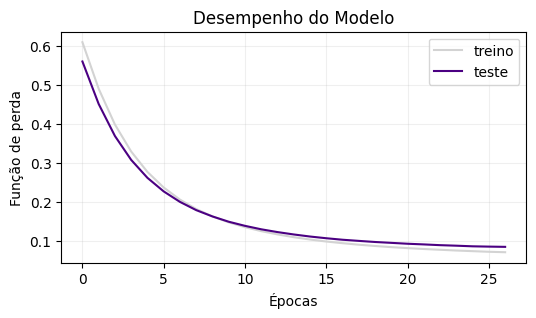

In [60]:
# Gráfico com a evolução do treinamento
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(historico.history['loss'], color='lightgray', label='treino')
plt.plot(historico.history['val_loss'], color='indigo', label='teste')
plt.title('Desempenho do Modelo')
plt.ylabel('Função de perda')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.show()

* Fazendo uma predição pontual:

In [61]:
# Predições para o conjunto de teste
ytest_pred_prob = model.predict(xtest_std)

# Convertendo probabilidades em classes (0 ou 1) usando um limiar de 0.7
ytest_pred_class = (ytest_pred_prob > 0.7).astype(int)

# Exibindo os valores reais e preditos
print(f'Valores y (real)\n{ytest[0:5]}')  # ytest contém as classes reais (0 ou 1)
print('---' * 10)
print(f'Valores de y (predito - probabilidades)\n{ytest_pred_prob[0:5]}')  # Probabilidades preditas
print('---' * 10)
print(f'Valores de y (predito - classes)\n{ytest_pred_class[0:5]}')  # Classes preditas (0 ou 1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Valores y (real)
[0 0 0 0 1]
------------------------------
Valores de y (predito - probabilidades)
[[0.29456237]
 [0.09449866]
 [0.30317074]
 [0.0667306 ]
 [0.7029714 ]]
------------------------------
Valores de y (predito - classes)
[[0]
 [0]
 [0]
 [0]
 [1]]


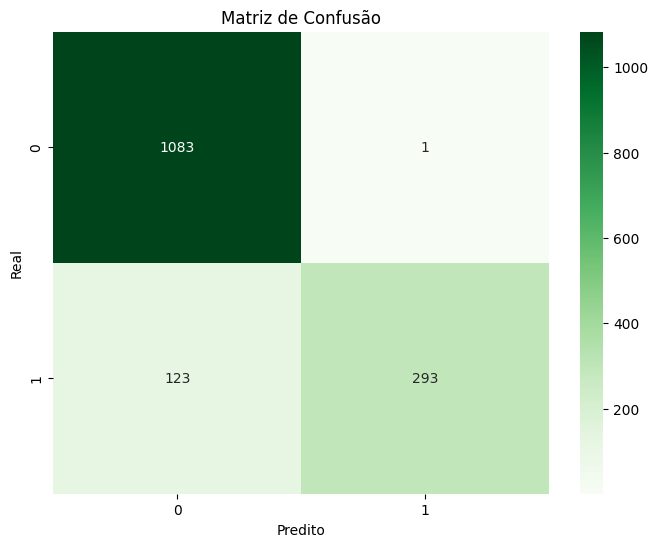

In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Gerando a matriz de confusão:
confusion_matrix = confusion_matrix(ytest, ytest_pred_class)

# Visualizando a matriz:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [63]:
# Gerando o relatório de classificação
report = classification_report(ytest, ytest_pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1084
           1       1.00      0.70      0.83       416

    accuracy                           0.92      1500
   macro avg       0.95      0.85      0.89      1500
weighted avg       0.93      0.92      0.91      1500



Lembrando:

* **Precision:** foca na qualidade das predições positivas. Útil quando o custo de prever um FP é alto.
* **Recall:** foca em encontrar o maior número possível de positivos reais. É importante quando o custo de um FN é alto.
* **F1-Score:** balanceia os dois, útil quando ambos são igualmente importantes.
* **Acurácia (Accuracy):**  proporção de todas as previsões corretas.

## **Modelagem: Detecção de anomalias**

Redes Neurais Artificais também podem ser utilizados em tarefas de aprendizado não supervisionado, como por exemplo, na detecção de anomalias.

Nesse caso, podemos utilizar um **AutoEncoder**, disponível na biblioteca `pyod`.

In [64]:
!pip install pyod -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 5.2 MB/s eta 0:00:00


In [65]:
# Bibliotecas:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# RNA AutoEncoder:
import pyod
from pyod.models.auto_encoder import AutoEncoder

In [66]:
# Dados:
dados = sns.load_dataset('tips')
dados.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [67]:
dados.shape

(244, 7)

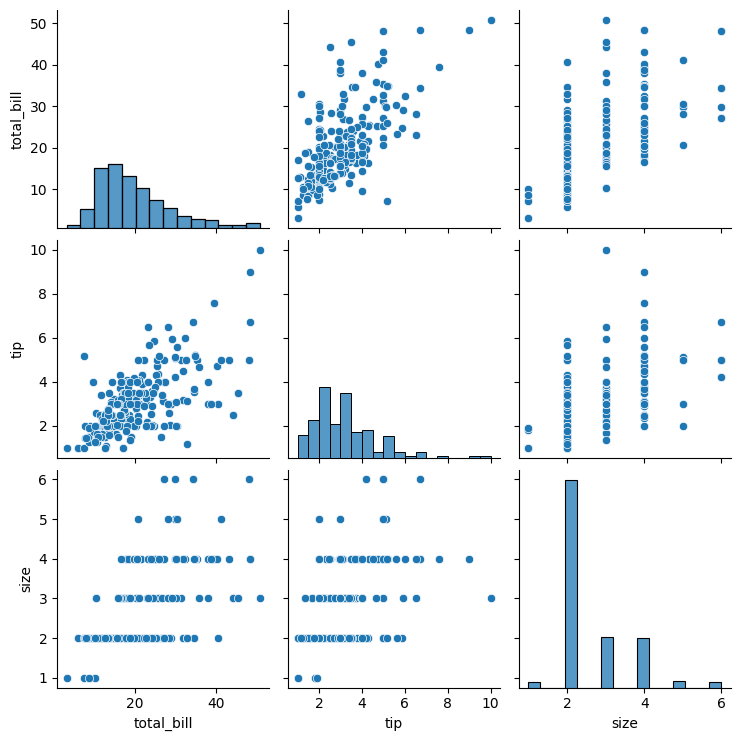

In [68]:
sns.pairplot(dados)

In [69]:
dados = dados.select_dtypes(include='number')

dados_treino = dados.sample(n = int(0.8*len(dados)))
dados_teste = dados.sample(n = int(0.2*len(dados)))

print(dados_treino.shape)
print(dados_teste.shape)

(195, 3)
(48, 3)


In [70]:
scaler = StandardScaler()

# Scaling:
dados_treino_std = scaler.fit_transform(dados_treino)
dados_teste_std = scaler.fit_transform(dados_teste)

print(dados_treino_std.shape)
print(dados_teste_std.shape)

(195, 3)
(48, 3)


In [71]:
# Treino do modelo:
modelo_ae = AutoEncoder(hidden_neuron_list=[8, 4, 2, 4, 8], batch_size=32, epoch_num=50)
modelo_ae.fit(dados_treino_std)

Training: 100%|██████████| 50/50 [00:05<00:00,  9.04it/s]


In [72]:
# Resultado das predições:
dados_treino['anomalia'] =  modelo_ae.predict(dados_treino_std)
dados_treino['score'] =  modelo_ae.decision_function(dados_treino_std)

In [73]:
dados.head()

,total_bill,tip,size
0,16.99,1.01,2
1,10.34,1.66,3
2,21.01,3.50,3
3,23.68,3.31,2
4,24.59,3.61,4


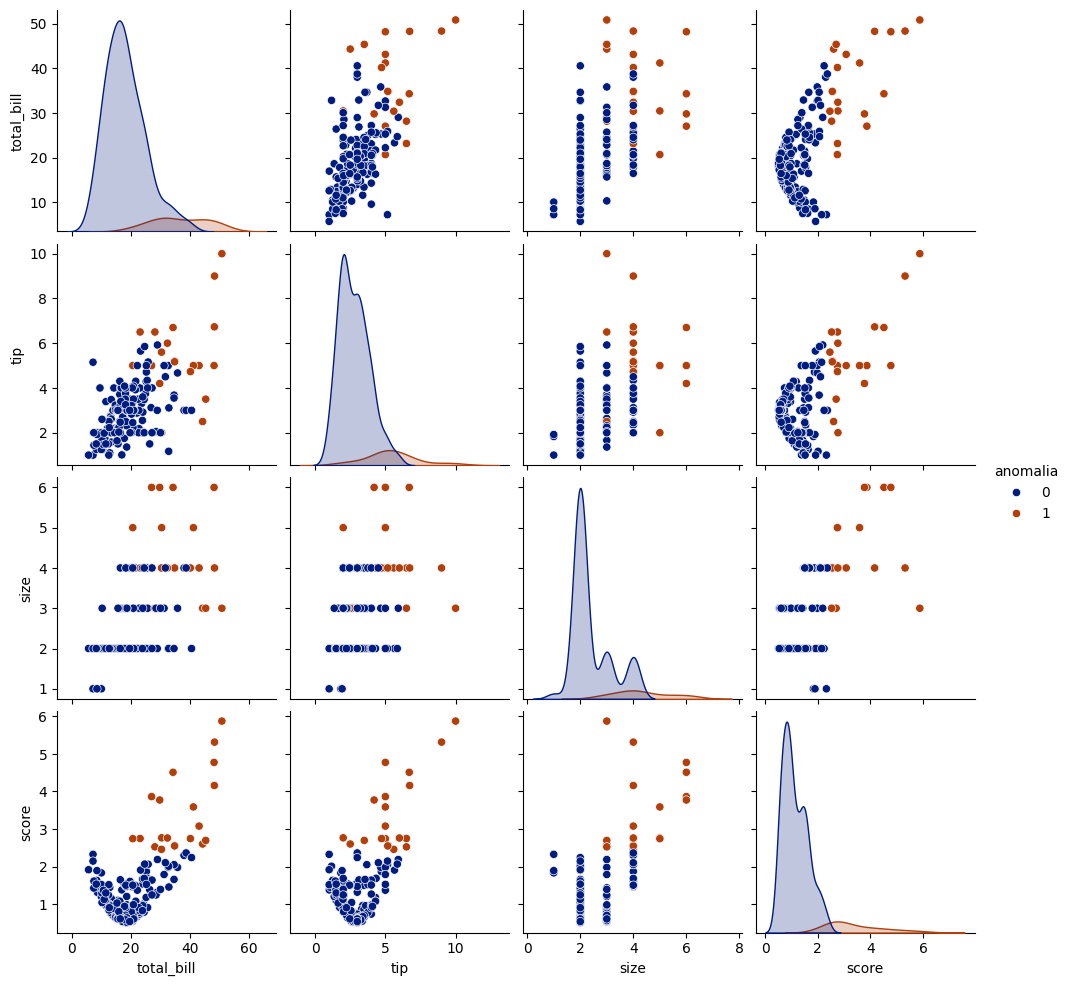

In [74]:
# Dispersão:
sns.pairplot(dados_treino, hue='anomalia', palette='dark')

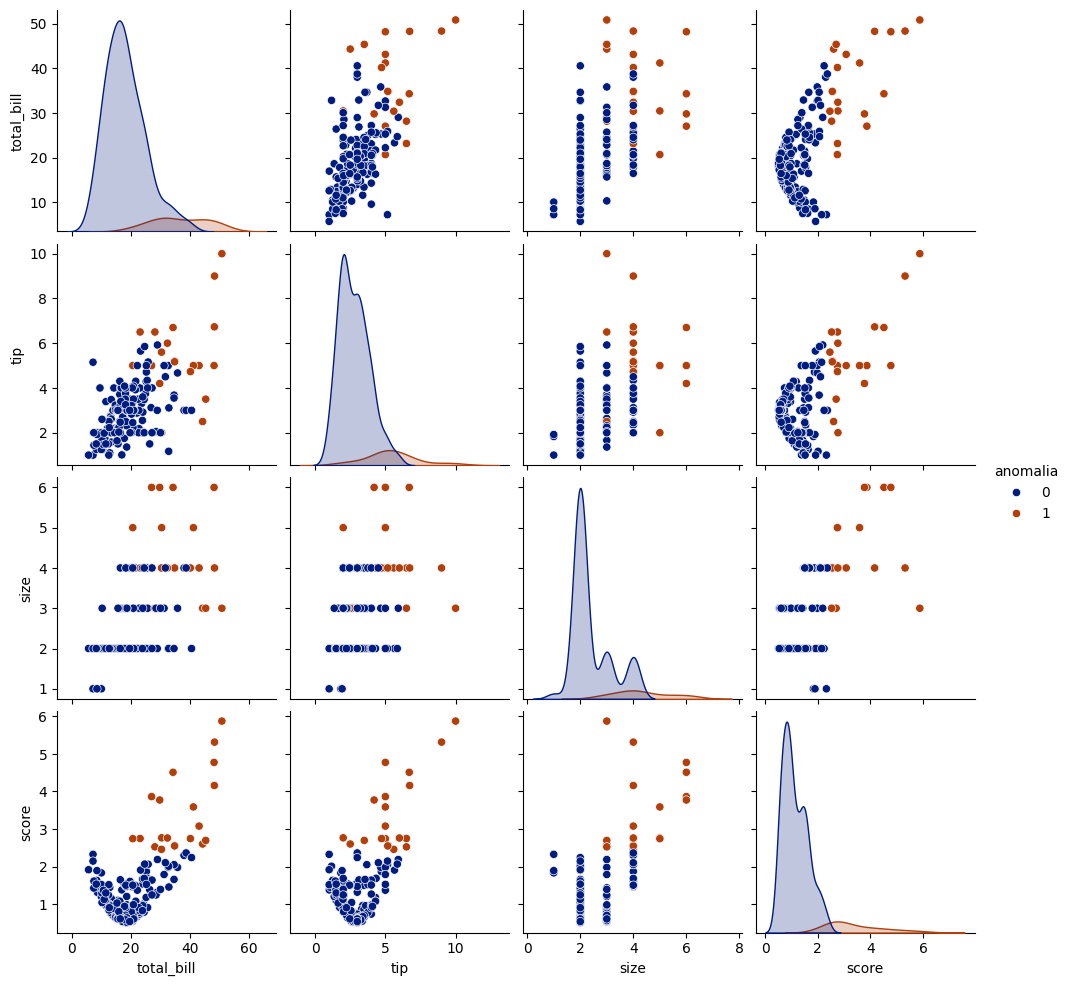

In [75]:
# Boxplot:
sns.pairplot(dados_treino, hue='anomalia', palette='dark')

In [76]:
# Treino do modelo:
modelo_ae.fit(dados_teste_std)

Training: 100%|██████████| 50/50 [00:00<00:00, 97.53it/s]


In [77]:
# Resultado das predições:
dados_teste['anomalia'] =  modelo_ae.predict(dados_teste_std)
dados_teste['score'] =  modelo_ae.decision_function(dados_teste_std)

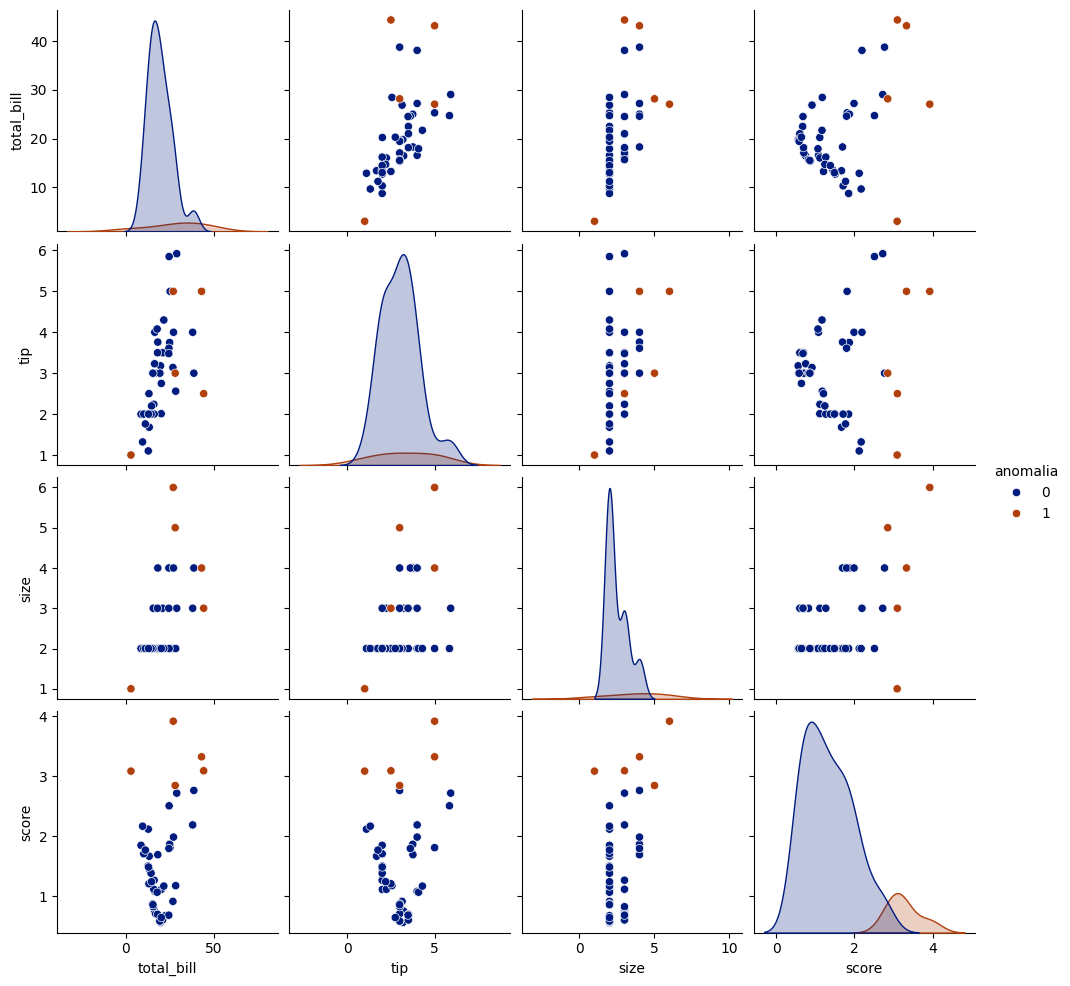

In [78]:
# Dispersão:
sns.pairplot(dados_teste, hue='anomalia', palette='dark')

<Axes: xlabel='score'>

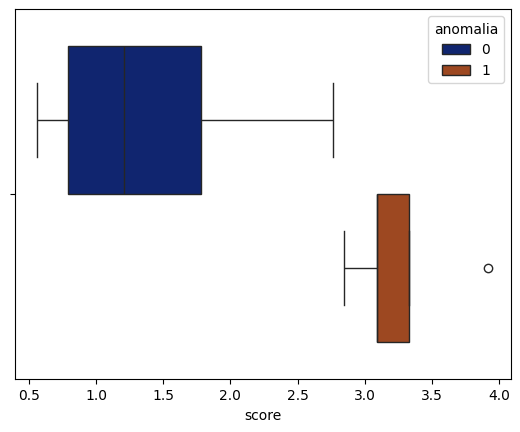

In [79]:
# Boxplot:
sns.boxplot(dados_teste, x='score', hue='anomalia', palette='dark')